# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

In [10]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'

# Load fitted params

In [112]:
fitted_params = pd.DataFrame()
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f)]
for modelname in modelnames:
    model_params = pd.read_csv(os.path.join(fitted_param_dir, modelname))
    model_params['model'] = modelname.split('_')[1]
    fitted_params = fitted_params.append(model_params, sort=False)
fitted_params

,beta,persev,bias,alpha,nalpha,calpha,sID,slope_variable,fullID,animal,PreciseYrs,Gender,treatment,session,age_z,T1,PDS,cnalpha,model
0,3.997921,0.0,-0.012619,0.557001,0.557001,0.995067,1404012,age_z,1404012,14,40,Male,2,0,-1.052498,0,0,0.0,RLabcd
1,3.201425,0.0,-0.121497,0.752223,0.752223,0.362169,1404112,age_z,1404112,14,41,Male,2,1,-0.997847,0,0,0.0,RLabcd
2,2.821934,0.0,-0.198866,0.798179,0.798179,0.453855,1404212,age_z,1404212,14,42,Male,2,2,-0.943196,0,0,0.0,RLabcd
3,5.881093,0.0,0.021581,0.832955,0.832955,0.987737,1404312,age_z,1404312,14,43,Male,2,3,-0.888545,0,0,0.0,RLabcd
4,4.838022,0.0,-0.029231,0.702183,0.702183,0.220017,1404412,age_z,1404412,14,44,Male,2,4,-0.833894,0,0,0.0,RLabcd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,4.244455,0.0,0.000000,0.816176,0.816176,0.000000,1308521,age_z,1308521,13,85,Female,1,11,1.406801,0,0,0.0,RLab
435,5.005864,0.0,0.000000,0.757420,0.757420,0.000000,1308621,age_z,1308621,13,86,Female,1,12,1.461452,0,0,0.0,RLab
436,3.639687,0.0,0.000000,0.758838,0.758838,0.000000,1308821,age_z,1308821,13,88,Female,1,13,1.570754,0,0,0.0,RLab
437,5.201467,0.0,0.000000,0.781846,0.781846,0.000000,1308921,age_z,1308921,13,89,Female,1,14,1.625405,0,0,0.0,RLab


In [113]:
fitted_params_ = fitted_params.copy()
fitted_params_['beta'] /= 20
fitted_params_long = fitted_params_.melt(
    id_vars=['sID', 'slope_variable', 'fullID', 'animal', 'PreciseYrs', 'Gender', 'treatment',
             'session', 'age_z', 'T1', 'PDS', 'model'],
    value_name='param_value', var_name='param'
)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\fitted_params.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


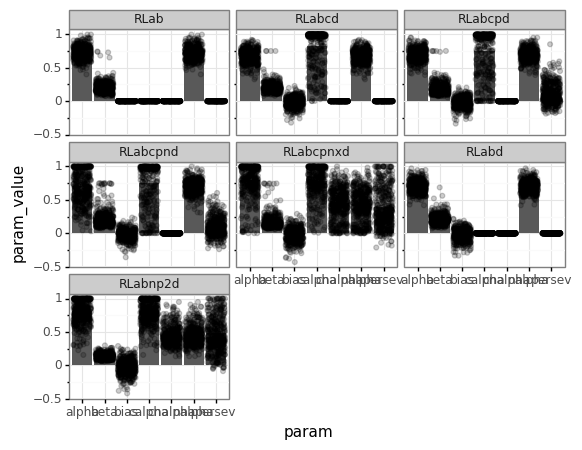

In [114]:
g = (gg.ggplot(fitted_params_long, gg.aes('param', 'param_value'))
 + gg.stat_summary(geom='bar')
 + gg.geom_point(position='jitter', alpha=0.2)
 + gg.facet_wrap('~ model')
)
g.draw()
g.save(os.path.join(plot_dir, 'fitted_params.png'))

# Simulate data

In [44]:
params = pd.DataFrame({
    'alpha': [0.8], 'nalpha': [0.1], 'calpha': [0.9], 'cnalpha': [0.1],
    'beta': [4], 'persev': [0.2], 'bias': [0]
})
init_Q = 1/2
n_agents = 100

In [45]:
class PSAgent():
    
    def __init__(self, n_agents, params, init_Q, eps=1e-5):
        self.n_agents = n_agents
        self.params = params
        self.avail_actions = (0, 1)
        self.init_Q = init_Q
        self.Q = init_Q * np.ones((n_agents, len(self.avail_actions)))
        self.eps = eps
        self.prev_action = np.full(n_agents, np.nan)
        
    def take_action(self):
        """
        Take 1 action per agent, based on current trial Q-values.
        """
        
        ags = np.arange(self.n_agents)

        # Perseveration
        Q0 = self.Q[ags, 0]
        Q1 = self.Q[ags, 1]
        if not np.isnan(self.prev_action[0]):  # prev_action is np.nan on trial 0 only; only checking first element for simplicity
            Q0 += (1 - self.prev_action) * self.params['persev'].values  # action 0: subtract persev when repeating
            Q1 += self.prev_action * self.params['persev'].values   # action 1: add persev when repeating

        # Action selection
        lik = scipy.special.softmax(self.params['beta'].values * np.array([Q0, Q1]).T, axis=1)
        action = np.array([np.random.choice(self.avail_actions, p=lik[a]) for a in range(self.n_agents)])
        self.prev_action = action.copy()
        
        lik = self.eps / 2 + (1 - self.eps) + lik  # squeeze between eps and 1-eps to avoid 0's and 1's
        
        return lik, action
    
    def update_Q(self, action, reward):
        """
        Update Q-values based on RL.
        """
        
        ags = np.arange(self.n_agents)
        
        rpe = (1 - self.Q[ags, action]) * reward  # received reward, updating chosen action
        nrpe = (0 - self.Q[ags, action]) * (1 - reward)  # received no reward, updating chosen action
        
        crpe = (0 - self.Q[ags, 1-action]) * reward  # received reward, updating unchosen action
        cnrpe = (1 - self.Q[ags, 1-action]) * (1 - reward)  # received no reard, updating unchosen action
        
        self.Q[ags, action] += self.params['alpha'].values * rpe + self.params['nalpha'].values * nrpe
        self.Q[ags, 1-action] += self.params['calpha'].values * crpe + self.params['cnalpha'].values * cnrpe


# Example use:
agent = PSAgent(n_agents, params, init_Q)
lik, action = agent.take_action()
print("action", action)
correct, reward = task.present_reward(action, trial)
print("reward", reward)
agent.update_Q(action, reward)
print("agent.Q", agent.Q)

action [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0
 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0]
reward [1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1
 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0]
agent.Q [[0.9  0.05]
 [0.45 0.55]
 [0.55 0.45]
 [0.45 0.55]
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 [0.9  0.05]
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 [0.9  0.05]
 [0.55 0.45]
 [0.55 0.45]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.45 0.55]
 [0.9  0.05]
 [0.9  0.05]
 [0.45 0.55]
 [0.9  0.05]
 [0.55 0.45]
 [0.9  0.05]
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 [0.9  0.05]
 [0.45 0.55]
 [0.55 0.45]
 [0.55 0.45]
 [0.55 0.45]
 [0.9  0.05]
 [0.55 0.45]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.9  0.05]
 [0.55 0.45]
 [0.55 0.45

In [46]:
n_trials = 200
p_cor = 0.75
block_lengths_lower = 40
block_lengths_upper = 41

In [47]:
class PSTask():
    
    def __init__(self, p_cor, correct_actions, n_trials, block_lengths_lower, block_lengths_upper):
        """
        Must either provide block_lengths_lower and block_lengths_upper -> task will be created on the fly;
        or correct_actions -> provided task will be used.
        """
        
        self.p_cor = p_cor

        if len(correct_actions) > 0:
            self.correct_actions = correct_actions
            self.n_trials = len(correct_actions)
        elif block_lengths_lower: 
            self.block_lengths_lower = block_lengths_lower
            self.block_lengths_upper = block_lengths_upper
            self.n_trials = n_trials
            self.correct_actions = self.make_task()
        else:
            raise ValueError("You must provide either correct_actions or block_lengths_lower.")
        
    def make_task(self):
        """
        Currently just produces the same sequence of correct and incorrect boxes for each animal.
        In future, will read in animal data.
        """
        
        correct_actions = []
        block_lengths = np.random.randint(
            low=self.block_lengths_lower, high=self.block_lengths_upper, size=self.n_trials)

        for block_length, correct_side in zip(block_lengths, [0, 1] * self.n_trials):
            correct_actions += block_length * [correct_side]
        
        correct_actions = correct_actions[:self.n_trials]
        
        return correct_actions
        
    def get_chance_rewards(self, n_correct_choices):
        """
        Translate accuracy into rewards:
        Return '1' with probability self.p_cor and '0' with probability 1-self.p_cor, for each agent.
        """
        
        return np.array([np.random.choice((0, 1), p=(1-self.p_cor, self.p_cor)) for i in range(n_correct_choices)])

    def present_reward(self, action, trial):
        """
        Present reward (0, 1) for each agent in this trial, based on choices,
        by consulting the correct_box on the current trial.
        """
        
        correct = np.array(self.correct_actions[trial] == action).astype(int)
        reward = correct.copy()
        reward[reward == 1] = self.get_chance_rewards(sum(reward==1))
        
        return correct, reward
    
# Example use
task = PSTask(
    p_cor, n_trials=n_trials, block_lengths_lower=block_lengths_lower, block_lengths_upper=block_lengths_upper,
    correct_actions=[])
task.make_task()

task.get_chance_rewards(n_correct_choices=100)

action = np.zeros(n_agents)
trial = 0
task.present_reward(action, trial)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]))

In [48]:
def simulate_dataset(task_args, agent_args):
    
    actions = []
    liks = []
    rewards = []
    corrects = []
    correct_actions = []

    # Get task and agent
    task = PSTask(task_args['p_cor'], n_trials=task_args['n_trials'],
                  block_lengths_lower=task_args['block_lengths_lower'], block_lengths_upper=task_args['block_lengths_upper'],
                  correct_actions=task_args['correct_actions'])
    agent = PSAgent(agent_args['n_agents'], agent_args['params'], agent_args['init_Q'])

    # Play the game, save data
    for trial in range(n_trials):

        lik, action = agent.take_action()
        correct, reward = task.present_reward(action, trial)
        agent.update_Q(action, reward)

        actions += [action]
        liks += [lik]
        rewards += [reward]
        corrects += [correct]
        correct_actions += [task.correct_actions]

    # Format data
    data = pd.DataFrame(
            {'action': actions, 'lik': liks,
             'reward': rewards, 'correct': corrects, 'correct_action': correct_actions})
    data = data.reset_index()
    data = data.rename(columns={'index': 'trial'})

    data['mean_reward'] = np.mean(np.array(list(data.reward)), axis=1)
    data['mean_correct'] = np.mean(np.array(list(data.correct)), axis=1)
    data['block'] = np.append([0], np.cumsum(np.abs(np.diff(task.correct_actions))))

    return data

# Example use
task_args = {
    'p_cor': 0.75, 'correct_actions': [], 'n_trials': n_trials,
    'block_lengths_lower': block_lengths_lower, 'block_lengths_upper': block_lengths_upper
}
agent_args = {
    'n_agents': n_agents, 'params': params, 'init_Q': init_Q,
}

data = simulate_dataset(task_args, agent_args)
data

,trial,action,lik,reward,correct,correct_action,mean_reward,mean_correct,block
0,0,"[0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[[1.499995, 1.499995], [1.499995, 1.499995], [...","[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, ...","[1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.39,0.52,0
1,1,"[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[[1.9852209683067275, 1.0147690316932731], [1....","[1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...","[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.35,0.62,0
2,2,"[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...","[[1.9909817013471525, 1.009008298652848], [1.4...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.54,0.73,0
3,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[[1.9916854042120178, 1.0083045957879828], [1....","[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.66,0.89,0
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[[1.981720408642414, 1.018269591357586], [1.98...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.71,0.91,0
...,...,...,...,...,...,...,...,...,...
195,195,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.990795710031714, 1.0091942899682862], [1.9...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.73,0.98,4
196,196,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.9799877094853051, 1.0200022905146955], [1....","[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.66,0.98,4
197,197,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.9601578709627863, 1.0398321290372143], [1....","[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.76,1.00,4
198,198,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[1.9895971467948206, 1.0103928532051798], [1....","[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.75,0.98,4


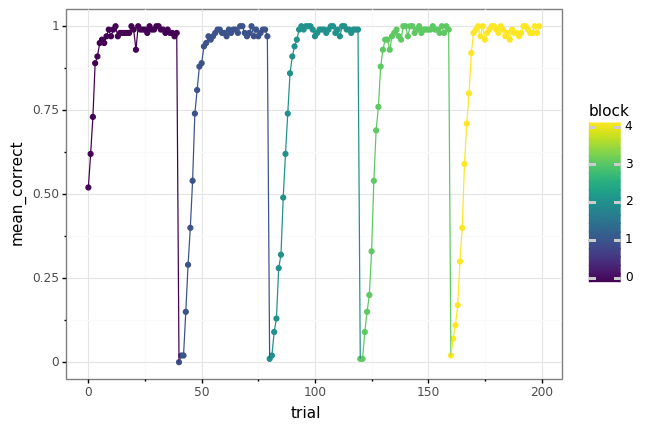

<ggplot: (-9223371896142272666)>

In [49]:
(gg.ggplot(data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
)

# Simulated mouse data from fitted params

In [50]:
true_dat

,animal,age,action,reward,correct,correct_action,trial,block,gender,agegroup,fullID,block_trial,session
0,14,40,0,0,0,1,0,0,1,2,1404012,0.0,0.0
1,14,40,0,0,0,1,1,0,1,2,1404012,1.0,0.0
2,14,40,1,1,1,1,2,0,1,2,1404012,2.0,0.0
3,14,40,1,1,1,1,3,0,1,2,1404012,3.0,0.0
4,14,40,1,1,1,1,4,0,1,2,1404012,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,13,90,0,0,1,0,720,29,2,1,1309021,25.0,18.0
721,13,90,0,1,1,0,721,29,2,1,1309021,26.0,18.0
722,13,90,0,1,1,0,722,29,2,1,1309021,27.0,18.0
723,13,90,0,1,1,0,723,29,2,1,1309021,28.0,18.0


In [56]:
param_names = ['alpha', 'nalpha', 'calpha', 'cnalpha', 'beta', 'persev', 'bias']
model_name = 'RLab'
n_agents = 2

In [109]:
fitted_params

,beta,persev,bias,alpha,nalpha,calpha,sID,slope_variable,fullID,animal,PreciseYrs,Gender,treatment,session,age_z,T1,PDS,cnalpha,model
0,3.997921,0.0,-0.012619,0.557001,0.557001,0.995067,1404012,age_z,1404012,14,40,Male,2,0,-1.052498,0,0,0.0,RLabcd
1,3.201425,0.0,-0.121497,0.752223,0.752223,0.362169,1404112,age_z,1404112,14,41,Male,2,1,-0.997847,0,0,0.0,RLabcd
2,2.821934,0.0,-0.198866,0.798179,0.798179,0.453855,1404212,age_z,1404212,14,42,Male,2,2,-0.943196,0,0,0.0,RLabcd
3,5.881093,0.0,0.021581,0.832955,0.832955,0.987737,1404312,age_z,1404312,14,43,Male,2,3,-0.888545,0,0,0.0,RLabcd
4,4.838022,0.0,-0.029231,0.702183,0.702183,0.220017,1404412,age_z,1404412,14,44,Male,2,4,-0.833894,0,0,0.0,RLabcd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,4.244455,0.0,0.000000,0.816176,0.816176,0.000000,1308521,age_z,1308521,13,85,Female,1,11,1.406801,0,0,0.0,RLab
435,5.005864,0.0,0.000000,0.757420,0.757420,0.000000,1308621,age_z,1308621,13,86,Female,1,12,1.461452,0,0,0.0,RLab
436,3.639687,0.0,0.000000,0.758838,0.758838,0.000000,1308821,age_z,1308821,13,88,Female,1,13,1.570754,0,0,0.0,RLab
437,5.201467,0.0,0.000000,0.781846,0.781846,0.000000,1308921,age_z,1308921,13,89,Female,1,14,1.625405,0,0,0.0,RLab


In [ ]:
sim_data = pd.DataFrame()
model_names = [modelname.split('_')[1] for modelname in modelnames]
for model_name in model_names:
    print(model_name, model_names)
    
    for animal, age in zip(animals, ages):
        if (animal != 23) and (age != 43):  # Error in the Juvi_AnimalID.csv - rerunning fitted_params with fixed one

            # Get task for this mouse
            true_sub = true_dat.loc[(true_dat.age == age) & (true_dat.animal == animal)]
            n_trials = len(np.unique(true_sub.trial))
            correct_actions = true_sub.correct_action.values

            # Get params
            params = fitted_params.loc[
                (fitted_params.PreciseYrs == age) & (fitted_params.animal == animal) & (fitted_params.model == model_name),
                param_names]
            task_args = {
                'p_cor': 0.75, 'correct_actions': correct_actions, 'n_trials': 0,
                'block_lengths_lower': False, 'block_lengths_upper': False
            }
            agent_args = {
                'n_agents': n_agents, 'params': params, 'init_Q': init_Q
            }

            sub_data = simulate_dataset(task_args, agent_args)
            sub_data['session'] = true_sub.session[0]
            sub_data['animal'] = animal
            sub_data['age'] = age
            sub_data['model'] = model_name

            sim_data = sim_data.append(sub_data)
sim_data

RLabcd 14 40
RLabcd 14 41
RLabcd 14 42
RLabcd 14 44
RLabcd 14 45
RLabcd 14 46
RLabcd 14 47
RLabcd 14 48
RLabcd 14 49
RLabcd 14 50
RLabcd 15 39
RLabcd 15 40
RLabcd 15 41
RLabcd 15 42
RLabcd 15 44
RLabcd 15 45
RLabcd 15 46
RLabcd 15 47
RLabcd 15 48
RLabcd 15 49
RLabcd 16 40
RLabcd 16 41
RLabcd 16 42
RLabcd 16 44
RLabcd 16 45
RLabcd 16 46
RLabcd 16 47
RLabcd 17 39
RLabcd 17 40
RLabcd 17 41
RLabcd 17 42
RLabcd 17 44
RLabcd 17 45
RLabcd 17 46
RLabcd 17 47
RLabcd 17 48
RLabcd 17 49
RLabcd 17 50
RLabcd 17 51
RLabcd 18 38
RLabcd 18 39
RLabcd 18 40
RLabcd 18 41
RLabcd 18 42
RLabcd 18 44
RLabcd 18 45
RLabcd 18 46
RLabcd 18 47
RLabcd 19 39
RLabcd 19 40
RLabcd 19 41
RLabcd 19 42
RLabcd 19 44
RLabcd 19 46
RLabcd 19 47
RLabcd 20 38
RLabcd 20 39
RLabcd 20 40
RLabcd 20 41
RLabcd 20 42
RLabcd 20 44
RLabcd 20 45
RLabcd 20 46
RLabcd 21 38
RLabcd 21 39
RLabcd 21 40
RLabcd 21 41
RLabcd 21 42
RLabcd 21 44
RLabcd 21 45
RLabcd 21 46
RLabcd 21 47
RLabcd 21 48
RLabcd 21 49
RLabcd 21 50
RLabcd 22 38
RLabcd 22 39

RLabcpd 1 81
RLabcpd 1 82
RLabcpd 1 83
RLabcpd 1 84
RLabcpd 1 85
RLabcpd 1 86
RLabcpd 1 87
RLabcpd 1 88
RLabcpd 2 74
RLabcpd 2 75
RLabcpd 2 76
RLabcpd 2 77
RLabcpd 2 78
RLabcpd 2 79
RLabcpd 2 80
RLabcpd 2 81
RLabcpd 2 82
RLabcpd 2 83
RLabcpd 2 84
RLabcpd 2 85
RLabcpd 2 86
RLabcpd 2 87
RLabcpd 2 88
RLabcpd 3 74
RLabcpd 3 75
RLabcpd 3 76
RLabcpd 3 77
RLabcpd 3 78
RLabcpd 3 79
RLabcpd 3 80
RLabcpd 3 81
RLabcpd 3 82
RLabcpd 3 83
RLabcpd 3 84
RLabcpd 3 85
RLabcpd 3 86
RLabcpd 3 87
RLabcpd 3 88
RLabcpd 4 74
RLabcpd 4 75
RLabcpd 4 76
RLabcpd 4 77
RLabcpd 4 78
RLabcpd 4 79
RLabcpd 4 80
RLabcpd 4 81
RLabcpd 4 82
RLabcpd 4 83
RLabcpd 4 84
RLabcpd 4 86
RLabcpd 4 87
RLabcpd 4 88
RLabcpd 5 74
RLabcpd 5 75
RLabcpd 5 76
RLabcpd 5 77
RLabcpd 5 78
RLabcpd 5 79
RLabcpd 5 80
RLabcpd 5 81
RLabcpd 5 82
RLabcpd 5 83
RLabcpd 5 84
RLabcpd 5 85
RLabcpd 5 86
RLabcpd 5 87
RLabcpd 5 88
RLabcpd 6 70
RLabcpd 6 71
RLabcpd 6 72
RLabcpd 6 73
RLabcpd 6 74
RLabcpd 6 75
RLabcpd 6 76
RLabcpd 6 77
RLabcpd 6 78
RLabcpd 6 79

RLabcpnd 13 86
RLabcpnd 13 88
RLabcpnd 13 89
RLabcpnd 13 90
RLabcpnxd 14 40
RLabcpnxd 14 41
RLabcpnxd 14 42
RLabcpnxd 14 44
RLabcpnxd 14 45
RLabcpnxd 14 46
RLabcpnxd 14 47
RLabcpnxd 14 48
RLabcpnxd 14 49
RLabcpnxd 14 50
RLabcpnxd 15 39
RLabcpnxd 15 40
RLabcpnxd 15 41
RLabcpnxd 15 42
RLabcpnxd 15 44
RLabcpnxd 15 45
RLabcpnxd 15 46
RLabcpnxd 15 47
RLabcpnxd 15 48
RLabcpnxd 15 49
RLabcpnxd 16 40
RLabcpnxd 16 41
RLabcpnxd 16 42
RLabcpnxd 16 44
RLabcpnxd 16 45
RLabcpnxd 16 46
RLabcpnxd 16 47
RLabcpnxd 17 39
RLabcpnxd 17 40
RLabcpnxd 17 41
RLabcpnxd 17 42
RLabcpnxd 17 44
RLabcpnxd 17 45
RLabcpnxd 17 46
RLabcpnxd 17 47
RLabcpnxd 17 48
RLabcpnxd 17 49
RLabcpnxd 17 50
RLabcpnxd 17 51
RLabcpnxd 18 38
RLabcpnxd 18 39
RLabcpnxd 18 40
RLabcpnxd 18 41
RLabcpnxd 18 42
RLabcpnxd 18 44
RLabcpnxd 18 45
RLabcpnxd 18 46
RLabcpnxd 18 47
RLabcpnxd 19 39
RLabcpnxd 19 40
RLabcpnxd 19 41
RLabcpnxd 19 42
RLabcpnxd 19 44
RLabcpnxd 19 46
RLabcpnxd 19 47
RLabcpnxd 20 38
RLabcpnxd 20 39
RLabcpnxd 20 40
RLabcpnxd 20

RLabd 31 46
RLabd 31 47
RLabd 32 38
RLabd 32 39
RLabd 32 40
RLabd 32 41
RLabd 32 42
RLabd 32 44
RLabd 32 45
RLabd 32 46
RLabd 32 47
RLabd 32 48
RLabd 32 49
RLabd 32 50
RLabd 33 41
RLabd 33 42
RLabd 33 44
RLabd 33 45
RLabd 33 46
RLabd 33 47
RLabd 33 48
RLabd 33 49
RLabd 33 50
RLabd 33 51
RLabd 33 52
RLabd 33 53
RLabd 34 40
RLabd 34 41
RLabd 34 42
RLabd 34 44
RLabd 34 45
RLabd 34 46
RLabd 34 47
RLabd 34 48
RLabd 34 49
RLabd 34 50
RLabd 35 39
RLabd 35 40
RLabd 35 41
RLabd 35 42
RLabd 35 44
RLabd 35 45
RLabd 35 46
RLabd 35 47
RLabd 35 48
RLabd 35 49
RLabd 35 50
RLabd 36 40
RLabd 36 41
RLabd 36 42
RLabd 36 45
RLabd 36 46
RLabd 36 47
RLabd 36 48
RLabd 36 49
RLabd 37 45
RLabd 37 48
RLabd 37 50
RLabd 37 52
RLabd 37 54
RLabd 37 56
RLabd 37 58
RLabd 37 60
RLabd 1 75
RLabd 1 76
RLabd 1 77
RLabd 1 78
RLabd 1 79
RLabd 1 80
RLabd 1 81
RLabd 1 82
RLabd 1 83
RLabd 1 84
RLabd 1 85
RLabd 1 86
RLabd 1 87
RLabd 1 88
RLabd 2 74
RLabd 2 75
RLabd 2 76
RLabd 2 77
RLabd 2 78
RLabd 2 79
RLabd 2 80
RLabd 2 81
RL

RLabnp2d 11 83
RLabnp2d 11 84
RLabnp2d 11 85
RLabnp2d 11 86
RLabnp2d 11 87
RLabnp2d 11 88
RLabnp2d 12 74
RLabnp2d 12 75
RLabnp2d 12 76
RLabnp2d 12 77
RLabnp2d 12 79
RLabnp2d 12 80
RLabnp2d 12 82
RLabnp2d 12 83
RLabnp2d 12 85
RLabnp2d 12 86
RLabnp2d 12 88
RLabnp2d 12 89
RLabnp2d 12 90
RLabnp2d 13 72
RLabnp2d 13 73
RLabnp2d 13 74
RLabnp2d 13 75
RLabnp2d 13 76
RLabnp2d 13 77
RLabnp2d 13 79
RLabnp2d 13 80
RLabnp2d 13 81
RLabnp2d 13 82
RLabnp2d 13 83
RLabnp2d 13 85
RLabnp2d 13 86
RLabnp2d 13 88
RLabnp2d 13 89
RLabnp2d 13 90
RLab 14 40
RLab 14 41
RLab 14 42
RLab 14 44
RLab 14 45
RLab 14 46
RLab 14 47
RLab 14 48
RLab 14 49
RLab 14 50
RLab 15 39
RLab 15 40
RLab 15 41
RLab 15 42
RLab 15 44
RLab 15 45
RLab 15 46
RLab 15 47
RLab 15 48
RLab 15 49
RLab 16 40
RLab 16 41
RLab 16 42
RLab 16 44
RLab 16 45
RLab 16 46
RLab 16 47
RLab 17 39
RLab 17 40
RLab 17 41
RLab 17 42
RLab 17 44
RLab 17 45
RLab 17 46
RLab 17 47
RLab 17 48
RLab 17 49
RLab 17 50
RLab 17 51
RLab 18 38
RLab 18 39
RLab 18 40
RLab 18 41
RL

In [ ]:
sim_data.shape

In [ ]:
sim_data.to_csv(os.path.join(fitted_param_dir, 'simulated_mice_nagents{}.csv'.format(n_agents)))

In [ ]:
gg.options.figure_size = (10, 10)
(gg.ggplot(sim_data, gg.aes('trial', 'mean_correct', color='block'))
 + gg.geom_point()
 + gg.geom_line()
 + gg.facet_grid('session ~ animal')
)

# Next steps
* Simulate all mice, all sessions, based on fitted parameters
* Save as csvs
* Option A) Read into R and analyze in the same way as humans
* Option B) Reimplement the analyses in python and analyze there
* Bring actual mouse data into the dame shape and analyze in the same way
* Compare models
* Average over mice